In [1]:
%pwd
%cd ../..

/Users/ryandevera/data-science/umn_environments/Deeplifting


In [2]:
import pandas as pd

In [3]:
files = [
    './results/results-2023-08-3-layer-512-sum-ackley_3d-0-particle-leaky_reluhigh-dimensional.parquet',
    './results/results-2023-08-3-layer-512-sum-ackley_5d-0-particle-leaky_reluhigh-dimensional.parquet',
    './results/results-2023-08-3-layer-512-sum-ackley_30d-0-particle-leaky_reluhigh-dimensional.parquet',
    './results/results-2023-08-3-layer-512-sum-ackley_100d-0-particle-leaky_reluhigh-dimensional.parquet',
]

In [4]:
df = pd.read_parquet(files)

In [5]:
df

,x1,x2,x3,f,algorithm,total_time,input_size,hidden_size,hidden_activation,output_activation,agg_function,problem_name,global_minimum,dimensions
0,-1.093596e-07,-1.086391e-08,5.730915e-08,2.862346e-07,Deeplifting,119.070853,512,512-512-512,sine,leaky_relu,sum,ackley_3d,0.0,3
1,-2.362199e-10,-6.691891e-10,9.578308e-09,2.315031e-08,Deeplifting,995.560220,512,512-512-512,sine,leaky_relu,sum,ackley_5d,0.0,5
2,1.844665e-07,-1.427955e-07,-1.505370e-07,3.897032e-07,Deeplifting,5703.610024,512,512-512-512,sine,leaky_relu,sum,ackley_30d,0.0,30
3,-1.600911e-08,2.234648e-08,-7.853131e-09,1.255706e-07,Deeplifting,42608.341140,512,512-512-512,sine,leaky_relu,sum,ackley_100d,0.0,100


<Axes: >

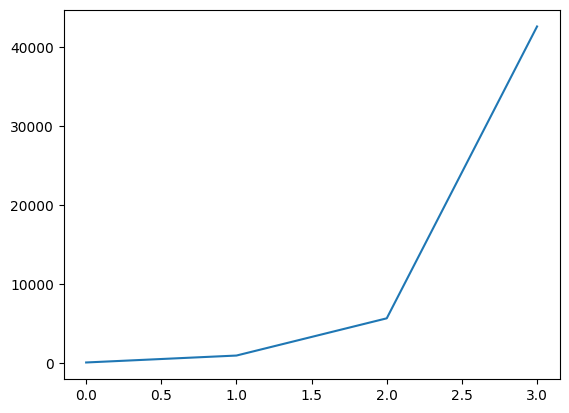

In [46]:
df['total_time'].plot()

In [6]:
import torch
import numpy as np
from deeplifting.problems import HIGH_DIMENSIONAL_PROBLEMS_BY_NAME

problem = HIGH_DIMENSIONAL_PROBLEMS_BY_NAME['ackley_2500d']

In [ ]:
x = torch.zeros(2500)
results = np.zeros((1, 1, 2500 + 1))
trial = 0

In [ ]:
%%timeit
f = problem['objective']
f(x, results=results, trial=trial, version='pytorch')

In [ ]:
%%timeit
multi_result = [x] * 512
f_list = []
for xr in multi_result:
    r = f(xr, results=results, trial=trial, version='pytorch')
    f_list.append(r)

# Figure out performance

In [7]:
import time

from pygranso.private.getNvar import getNvarTorch
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct
from deeplifting.optimization import deeplifting_nd_fn, deeplifting_predictions
from deeplifting.utils import HaltLog

# first party
from deeplifting.models import DeepliftingSkipMLP

In [8]:
def ndschwefel(x, version='pytorch'):
    """
    Implemention of the n-dimensional levy function

    Args:
    x: A d-dimensional array or tensor
    version: A string, either 'numpy' or 'pytorch'

    Returns:
    result: Value of the Rastrigin function
    """
    x = x.flatten()
    d = len(x)
    if version == 'numpy':
        result = 418.9829 * d - np.sum(x * np.sin(np.sqrt(np.abs(x))))
    elif version == 'pytorch':
        result = 418.9829 * d - torch.sum(x * torch.sin(torch.sqrt(torch.abs(x))))
    else:
        raise ValueError(
            "Unknown version specified. Available options are 'numpy' and 'pytorch'."
        )

    return result

In [9]:
%%timeit
bounds = [(-32, 32)] * 2500

3.71 µs ± 113 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
# Deeplifting model with skip connections
model = DeepliftingSkipMLP(
    input_size=512,
    hidden_sizes=(512, 512, 512),
    output_size=2500,
    bounds=bounds,
    skip_every_n=1,
    activation='sine',
    output_activation='leaky_relu',
    agg_function='sum',
    seed=0,
)

In [ ]:
%%time
outputs = model(None)

In [ ]:
%%time
ndschwefel(outputs[0, :], version='pytorch')

In [ ]:
import tqdm


def deeplifting_nd_fn(model, objective, method='particle'):
    """
    Combined funtion used for PyGranso
    """
    outputs = model(inputs=None)

    # Get x1 and x2 so we can add the bounds
    # outputs = torch.sigmoid(outputs)
    # x = outputs.mean(axis=0)
    # print(f'Output x {x}')
    x, f = deeplifting_predictions(outputs, objective, method=method)

    return f

In [ ]:
%%time
fn = lambda x: objective(x, version='pytorch')
deeplifting_nd_fn(model, fn)

In [ ]:
device = torch.device('cpu')
dimensions = 2500
trials = 1
method = 'particle'
objective = ndschwefel

model = model.to(device=device, dtype=torch.double)
nvar = getNvarTorch(model.parameters())

# Setup a pygransoStruct for the algorithm
# options
opts = pygransoStruct()

# Inital x0
x0 = (
    torch.nn.utils.parameters_to_vector(model.parameters())
    .detach()
    .reshape(nvar, 1)
    .to(device=device, dtype=torch.double)
)

opts.x0 = x0
opts.torch_device = device
opts.print_frequency = 1
opts.limited_mem_size = 5
opts.stat_l2_model = False
opts.double_precision = True
opts.opt_tol = 1e-5
opts.maxit = 2

# results

# Set up the function with the results
fn = lambda x: objective(x, version='pytorch')  # noqa

# # Combined function
comb_fn = lambda model: deeplifting_nd_fn(
    model,
    fn,
    method=method,
)  # noqa

# Run the main algorithm
start_time = time.time()
soln = pygranso(var_spec=model, combined_fn=comb_fn, user_opts=opts)
end_time = time.time()
total_time = end_time - start_time

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm


def deeplifting_nd_fn(model, objective, method='particle'):
    """
    Combined funtion used for PyGranso
    """
    outputs = model(inputs=None)

    # Get x1 and x2 so we can add the bounds
    # outputs = torch.sigmoid(outputs)
    f = deeplifting_predictions(outputs, objective, method=method)

    return f


def deeplifting_predictions(x, objective, method='particle'):
    """
    Convert scaled values to the objective function
    """
    if method == 'particle':
        # Iterate over the objective values
        objective_values = []
        for i in range(len(x)):
            f = objective(x[i, :])
            objective_values.append(f)

        objective_values = torch.stack(objective_values)
        f = torch.min(objective_values)

    return f


bounds = [(-500, 500)] * 2
device = torch.device('cpu')

# Initialize model
model = DeepliftingSkipMLP(
    input_size=512,
    hidden_sizes=(1024, 1024, 1024),
    output_size=2,
    bounds=bounds,
    skip_every_n=1,
    activation='sine',
    output_activation='leaky_relu',
    agg_function='sum',
    seed=0,
)
model = model.to(device=device, dtype=torch.double)
model.train()

objective = ndschwefel

# Define the optimizer
# optimizer = optim.LBFGS(model.parameters(), lr=1e-3, line_search_fn='strong_wolfe')
optimizer = optim.Adam(model.parameters(), lr=1e-5)

criterion = lambda m: deeplifting_nd_fn(m, objective)

# Training loop
for epoch in range(250):
    # def closure():
    #     # Zero out the gradients
    #     optimizer.zero_grad()

    #     # The loss is the sum of the compliance
    #     loss = criterion(model)

    #     # Go through the backward pass and create the gradients
    #     loss.backward()

    #     return loss

    # # Step through the optimzer to update the data with the gradients
    # optimizer.step(closure)
    optimizer.zero_grad()

    loss = criterion(model)
    loss.backward()

    optimizer.step()

    print(criterion(model))

tensor(605.7597, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(597.0006, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(612.1114, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(610.3884, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(604.5798, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(576.3912, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(607.1440, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(583.8082, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(578.5348, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(596.5820, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(579.3502, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(576.7955, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(589.1145, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(579.2773, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(573.8949, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(584.5273, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(5

In [ ]:
%%timeit
criterion(model)

In [ ]:
%%time
criterion(model)